In [1]:
import os
import subprocess as sp
import nibabel as nib
import numpy as np
from scipy.stats import norm
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable

from config import root
import subprocess as sp
from nipype.interfaces import fsl, freesurfer

from tools.helpers import save_nii, mni2index, index2mni
import scipy
from scipy.special import gammaln
from scipy import ndimage
import scipy.ndimage.filters as filters
from scipy import signal as s
from scipy.ndimage import convolve
from tools.roi_selection import Cluster, Sphere
import matplotlib.gridspec as gridspec

In [2]:
dark = matplotlib.colors.LinearSegmentedColormap.from_list("", ["#000000","#888888"])
darkgray = matplotlib.colors.LinearSegmentedColormap.from_list("", ["#444444", "#444444"])
darkblue = matplotlib.colors.LinearSegmentedColormap.from_list("", ["#8888ff", "#0000ff"])
darkred = matplotlib.colors.LinearSegmentedColormap.from_list("", ["#ff8888","#ff0000"])
white = matplotlib.colors.LinearSegmentedColormap.from_list("", ["#ffffff","#ffffff"])

In [25]:
def create_subplots(n, ncols=None, **kwargs):
    
    if ncols is None:
        ncols = round(n ** .5)
        
    nrows = int(np.ceil(n / ncols))
    rest = n % ncols
    col_width = (ncols - rest) % 2 + 1
    padding = int((ncols - rest) * col_width / 2)
    fig = plt.figure(**kwargs)
    gs = gridspec.GridSpec(nrows, col_width * ncols)

    axes = []
    
    for i in range(n - (n % ncols)):
        row = i // ncols
        col = i % ncols
        ax = fig.add_subplot(gs[row, col * col_width : (col+1) * col_width])
        axes.append(ax)
        
    for j in range(n % ncols):
        ax = fig.add_subplot(gs[nrows-1, (padding + col_width * j): (padding + col_width * (j+1))])
        axes.append(ax)
        
    return fig, axes


def get_slices(peaks, axis="z", max_num=9):
    return sorted(peaks[axis].unique()[:max_num])


def fdr( zscores, q=.1, cV=1, invert_zscores=False, mask=None ):
    """
    Adapted from https://brainder.org/2011/09/05/fdr-corrected-fdr-adjusted-p-values/
    using a default value of cV
    """
    
    if mask is None:
        mask = np.ones(zscores.shape, dtype=bool)

    inv = -1 if invert_zscores else 1
    zscores = inv * zscores
    
    mask *= (zscores != 0)
    zscores = zscores[mask]
    pvals = norm.sf(zscores)
    
    oidx = np.argsort( pvals )
    pvals = pvals[oidx]
    
    V = pvals.size
    idx = np.arange(1, V+1)
    thrline = idx * q / ( V * cV )
    
    select = pvals <= thrline
    if len(pvals[select]):
        thr = np.max(pvals[select])
        zthr = zscores[oidx][select][-1] * inv
    else:
        thr = None
        zthr = None
        
    pcor = pvals * V * cV / idx
    oidx_r = np.argsort(oidx)
        
    padj = np.zeros(len(pvals))
    prev = 1
    
    for i in idx[::-1]:
        padj[i-1] = np.min( [prev, pvals[i-1] * V * cV / i] )
        prev = padj[i-1]
        
    return thr, zthr, pvals, thrline, pcor, padj


def get_axes_peaks(img, thr, axis=0, plot=True, invert=-1):
    
    smooth = ndimage.gaussian_filter(img, sigma=(1,1,1), order=0)

    im = smooth.mean(axis=axis)
    dim = img.shape
    dim = np.delete(np.array(dim), axis)
    
    xs2 = np.arange(dim[0])
    ys2 = im.mean(axis=1)
    ypeaks2 = s.find_peaks_cwt(ys2*invert, np.arange(1, 7))
    ypeaks2 = ypeaks2[(ys2[ypeaks2] * invert)> np.abs(thr)]

    xs3 = np.arange(dim[1])
    ys3 = im.mean(axis=0)
    ypeaks3 = s.find_peaks_cwt(ys3*invert, np.arange(1, 7))
    ypeaks3 = ypeaks3[(ys3[ypeaks3] * invert)> np.abs(thr)]
    
    if plot:
    
        fig = plt.figure()
        ax1 = fig.add_subplot(2,2,1)
        ax1.imshow(im, aspect="auto", cmap="hot")

        ax2 = fig.add_subplot(2,2,2)    
        ax2.plot(ys2, xs2, color="black")    
        ax2.plot(ys2[ypeaks2], ypeaks2, marker="o", linestyle="none", color="black")   
        ax2.set_ylim(dim[0], 0)
        ax2.set_xlim(ys2.max(), ys2.min()-.05)

        ax3 = fig.add_subplot(2,2,3)
        ax3.plot(xs3, ys3, color="black")
        ax3.plot(ypeaks3, ys3[ypeaks3], marker="o", linestyle="none", color="black")
        ax3.set_xlim(0, dim[1])
        ax3.set_ylim(ys3.min(), ys3.max())
        
    return ypeaks2, ypeaks3


def plot_slices(img, thr, slices, axis, ncols=None, figsize=4, **kwargs):
    
    index = [slice(None)]*3
    
    if ncols is None:
        ncols = round(len(slices) ** .5)
        
    nrows = int(np.ceil(len(slices) / ncols))

    idx = index.copy()
    idx[axis] = slices[0]
    size = np.array([ncols, nrows]) / np.rot90(img[tuple(idx)]).shape * np.mean(np.rot90(img[tuple(idx)]).shape) * figsize
    y, x = size
    fig, axes = create_subplots(len(slices), ncols=ncols, figsize=(y, x), **kwargs)
    
    for i, s in enumerate(slices):
        
        idx = index.copy()
        idx[axis] = s
        
        ax = axes[i]
            
        mni_flat = np.rot90(mni[tuple(idx)])
        ylim, xlim = mni_flat.shape
        
        ax.imshow(mni_flat, cmap=dark)

        im = (
            ax
            .imshow(
                np.rot90(img[tuple(idx)]), 
                cmap="Reds",
                aspect=1, 
                interpolation="nearest",
                vmax=-1.69,
                vmin=-5,
            )
        )

        ax.set_xlim(0, xlim-1)
        ax.set_ylim(ylim-1, 0)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title("%d" % (index2mni((s, s, s))[axis]), y=.8, x=.8, size="large", color="white")

    cbar_width = (1 / ncols) * .05
    cbar_height = (1 / nrows) * .4

    cbar_ax = fig.add_axes([1, 1-cbar_height, cbar_width, cbar_height])
    
    fig.colorbar(im, cax=cbar_ax, ticks=[-1.69, -3.1, -5])
        
    return fig, axes


def find_local_maxima( img, size, threshold ):
    
    img_max = filters.maximum_filter(img, size)
    maxima = (img == img_max)
    img_min = filters.minimum_filter(img, size)
    diff = ((img_max - img_min) > threshold)
    maxima[diff == 0] = 0

    labeled, num_objects = ndimage.label(maxima)
    slices = ndimage.find_objects(labeled)

    x, y, z = [], [], []
    for dz, dy, dx in slices:
        x_center = (dx.start + dx.stop - 1)/2
        x.append(x_center)
        y_center = (dy.start + dy.stop - 1)/2    
        y.append(y_center)
        z_center = (dz.start + dz.stop - 1)/2    
        z.append(z_center)
        
    return np.array((x, y, z)).T.astype(int)


def find_peaks( **kwargs ):
    """Wrapping fsl.Cluster and returning a pandas dataframe."""
    cmd = fsl.Cluster(**kwargs).cmdline
    p = sp.Popen(cmd, stdout=sp.PIPE, shell=True)

    # Process output
    lines = p.stdout.read().decode("utf-8").split('\n')
    hdr = lines[0].split('\t')
    data = [tuple(line.split('\t')) for line in lines[1:-1]]
    peaks = pd.DataFrame(
        data,
        columns=["index", "n", "peak", "x", "y", "z", "cx", "cy", "cz"],
    ).apply(pd.to_numeric)
    peaks.set_index("index", inplace=True)

    return peaks

## Get data

In [14]:
output = os.path.join(root, "data", "output")
fs_dir = os.path.join(root, "data", "in_analysis", "fs_subjects")
standard = os.path.join(root, "data", "in_analysis", "nii", "standard")
mni_path = os.path.join(standard, "MNI152_T1_2mm.nii.gz")
mni = nib.load(mni_path).get_data()
mask = os.path.join(root, "data", "in_analysis", "nii", "standard", "segmentation_seg.nii.gz")

# Level 3 contrasts
l3_loc = os.path.join(output, "loc_mixed_fx")
l3_out = os.path.join(output, "pop_decay_mixed_fx")
l2_out = os.path.join(output, "pop_decay_L2_fixedfx_warped")
contrasts = {
    "right_upper": os.path.join(l3_out, "0", "_fixedflameo0", "zstat1.nii.gz"), 
    "left_upper": os.path.join(l3_out, "1", "_fixedflameo0", "zstat1.nii.gz"), 
    "left_lower": os.path.join(l3_out, "2", "_fixedflameo0", "zstat1.nii.gz"), 
    "right_lower": os.path.join(l3_out, "3", "_fixedflameo0", "zstat1.nii.gz"), 
    "loc_priming": os.path.join(l3_out, "4", "_fixedflameo0", "zstat1.nii.gz"), 
    "loc_lag1_priming": os.path.join(l3_out, "5", "_fixedflameo0", "zstat1.nii.gz"), 
    "loc_lag2_priming": os.path.join(l3_out, "6", "_fixedflameo0", "zstat1.nii.gz"), 
    "clr_priming": os.path.join(l3_out, "7", "_fixedflameo0", "zstat1.nii.gz"), 
    "clr_lag1_priming": os.path.join(l3_out, "8", "_fixedflameo0", "zstat1.nii.gz"), 
    "clr_lag2_priming": os.path.join(l3_out, "9", "_fixedflameo0", "zstat1.nii.gz"), 
    "baseline": os.path.join(l3_out, "10", "_fixedflameo0", "zstat1.nii.gz"), 
    "loc_0": os.path.join(l3_loc, "0", "_fixedflameo0", "zstat1.nii.gz"),
    "loc_1": os.path.join(l3_loc, "1", "_fixedflameo0", "zstat1.nii.gz"),
    "loc_2": os.path.join(l3_loc, "2", "_fixedflameo0", "zstat1.nii.gz"),
    "loc_3": os.path.join(l3_loc, "3", "_fixedflameo0", "zstat1.nii.gz")
}

post = os.path.join(output, "postprocessing")
if not os.path.exists(post):
    os.mkdir(post)

# Axes
saggital = 0
coronal = 1
axial = 2

## Stimulus related activity

In [15]:
# qval = .1

# zstat = nib.load(contrasts["loc_3"]).get_data()
# thr, zthr, pvals, thrline, pcor, padj = fdr(zstat, q=qval, mask=None)

# fig, axes = plt.subplots(ncols=2, figsize=(12, 4))
# axes[0].plot(pvals, "k-")
# axes[0].plot(thrline, "k:")
# axes[0].set_xlabel("voxel")
# axes[0].set_ylabel("p")
# axes[1].plot(pvals, padj, "k.", markersize=.5)
# axes[1].hlines(qval, xmin=0, xmax=1, linestyle=":", color="#000000")
# axes[1].set_xlabel("p")
# axes[1].set_ylabel("q")
# _ = axes[0].set_title("FDR z-threshold %.2f (p<%.2f)" % (zthr, thr))
# _ = axes[1].set_title("FDR q-threshold %.2f" % qval)

In [16]:
# zstat = nib.load(contrasts["loc_1"]).get_data()

# qval = .1
# thr, zthr, pvals, thrline, pcor, padj = fdr(zstat, q=qval, mask=mask_ctx, invert_zscores=False)

# fig, axes = plt.subplots(ncols=2, figsize=(12, 4))
# axes[0].plot(pvals, "k-")
# axes[0].plot(thrline, "k:")
# axes[0].set_xlabel("voxel")
# axes[0].set_ylabel("p")
# axes[1].plot(pvals, padj, "k.", markersize=.5)
# axes[1].hlines(qval, xmin=0, xmax=1, linestyle=":", color="#000000")
# axes[1].set_xlabel("p")
# axes[1].set_ylabel("q")
# _ = axes[0].set_title("FDR z-threshold %.2f (p<%.2f)" % (zthr, thr))
# _ = axes[1].set_title("FDR q-threshold %.2f" % qval)

# print(
#     (pvals <= thr).sum(),
#     (pcor <= qval).sum(),
#     (padj <= qval).sum()
# )

## Mask from baseline and cortex

In [17]:
mask_ctx = nib.load(mask).get_data() == 2
base_mask = ndimage.filters.convolve(mask_ctx, np.ones((2,2,2)))

zstat = nib.load(contrasts["baseline"]).get_data()
thr, zthr, pvals, thrline, pcor, padj = fdr(zstat, q=.1, mask=None)

base_mask *= nib.load(contrasts["baseline"]).get_data() > zthr
# mask_img += nib.load(contrasts["left_upper"]).get_data() > z
# mask_img += nib.load(contrasts["left_lower"]).get_data() > z
# mask_img += nib.load(contrasts["right_upper"]).get_data() > z
# mask_img += nib.load(contrasts["right_lower"]).get_data() > z
# mask_img *= nib.load(mask).get_data() == 2

In [18]:
# Create nifti image.
img = nib.Nifti1Image(
    base_mask.astype(int),
    nib.load(contrasts["baseline"]).affine
)

# Save as nifti.
nib.save(img, os.path.join(post, "base_mask.nii.gz"))

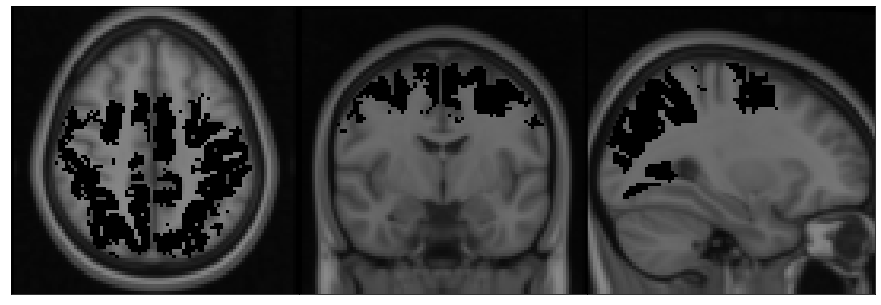

In [19]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,4))

axes[0].imshow(np.rot90(mni[:, 10:-10, 60]), cmap=dark, aspect="auto")
masked = np.ma.masked_array(base_mask[:, 10:-10, 60], base_mask[:, 10:-10, 60] == 0)
axes[0].imshow(np.rot90(masked), aspect="auto", cmap="gray")

axes[1].imshow(np.rot90(mni[:, 60, :]), cmap=dark, aspect="auto")
masked = np.ma.masked_array(base_mask[:, 60, :], base_mask[:, 60, :] == 0)
axes[1].imshow(np.rot90(masked), aspect="auto", cmap="gray")

axes[2].imshow(np.rot90(mni[30, 10:-10, :]), cmap=dark, aspect="auto")
masked = np.ma.masked_array(base_mask[30, 10:-10, :], base_mask[30, 10:-10, :] == 0)
axes[2].imshow(np.rot90(masked), aspect="auto", cmap="gray")

for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    
fig.subplots_adjust(left=0, hspace=0, wspace=0, right=1, top=1, bottom=0)

## Color lag1

4961 4961 4961


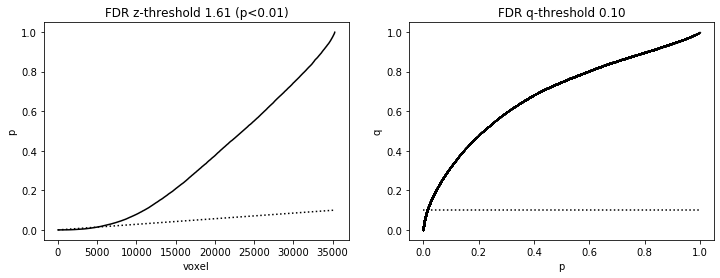

In [20]:
zstat = nib.load(contrasts["clr_lag1_priming"]).get_data()
clr1_masked = zstat * base_mask.astype(int)

# Create nifti image.
img = nib.Nifti1Image(clr1_masked, nib.load(contrasts["clr_lag1_priming"]).affine)
nib.save(img, os.path.join(post, "clr1_masked.nii.gz"))

qval = .1
clr1_thr, clr1_zthr, pvals, thrline, pcor, padj = fdr(zstat, q=qval, mask=base_mask, invert_zscores=True)

masked = np.ma.masked_array(clr1_masked, clr1_masked > clr1_zthr)
masked2 = masked * masked.mask

fig, axes = plt.subplots(ncols=2, figsize=(12, 4))
axes[0].plot(pvals, "k-")
axes[0].plot(thrline, "k:")
axes[0].set_xlabel("voxel")
axes[0].set_ylabel("p")
axes[1].plot(pvals, padj, "k.", markersize=.5)
axes[1].hlines(qval, xmin=0, xmax=1, linestyle=":", color="#000000")
axes[1].set_xlabel("p")
axes[1].set_ylabel("q")
_ = axes[0].set_title("FDR z-threshold %.2f (p<%.2f)" % (zthr, clr1_thr))
_ = axes[1].set_title("FDR q-threshold %.2f" % qval)

print(
    (pvals <= clr1_thr).sum(),
    (pcor <= qval).sum(),
    (padj <= qval).sum()
)

In [21]:
clr1_peaks = find_peaks( in_file=os.path.join( post, "clr1_masked.nii.gz" ), threshold=clr1_zthr, find_min=True, args="--minextent=8" )
slices = get_slices(clr1_peaks, axis="z", max_num=9)

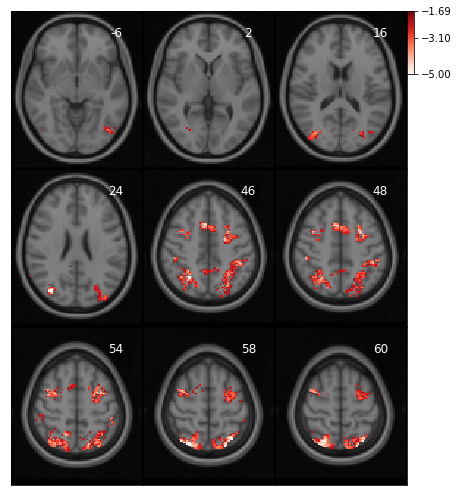

In [26]:
fig, axes = plot_slices(masked, clr1_zthr, slices, axial, ncols=3, figsize=2)
fig.subplots_adjust(wspace=0, hspace=0, top=1, bottom=0, left=0, right=1)

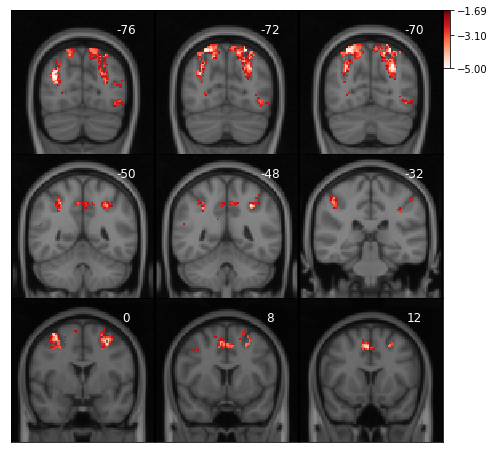

In [27]:
fig, axes = plot_slices(masked, clr1_thr, get_slices(clr1_peaks, axis="y", max_num=9), coronal, ncols=3, figsize=2)
fig.subplots_adjust(wspace=0, hspace=0, top=1, bottom=0, left=0, right=1)

## Color lag 2

55 48 55


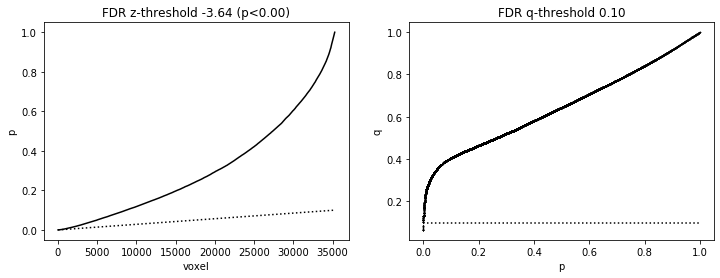

In [28]:
zstat = nib.load(contrasts["clr_lag2_priming"]).get_data()
clr2_masked = zstat * base_mask.astype(int)
aff = nib.load(contrasts["clr_lag2_priming"]).affine
save_nii(clr2_masked, aff, os.path.join(post, "clr2_masked.nii.gz"))

qval = .1
clr2_thr, clr2_zthr, pvals, thrline, pcor, padj = fdr(zstat, q=qval, mask=base_mask, invert_zscores=True)

masked = np.ma.masked_array(clr2_masked, clr2_masked > clr2_zthr)
masked2 = masked * masked.mask

fig, axes = plt.subplots(ncols=2, figsize=(12, 4))
axes[0].plot(pvals, "k-")
axes[0].plot(thrline, "k:")
axes[0].set_xlabel("voxel")
axes[0].set_ylabel("p")
axes[1].plot(pvals, padj, "k.", markersize=.5)
axes[1].hlines(qval, xmin=0, xmax=1, linestyle=":", color="#000000")
axes[1].set_xlabel("p")
axes[1].set_ylabel("q")
_ = axes[0].set_title("FDR z-threshold %.2f (p<%.2f)" % (clr2_zthr, clr2_thr))
_ = axes[1].set_title("FDR q-threshold %.2f" % qval)

print(
    (pvals <= clr2_thr).sum(),
    (pcor <= qval).sum(),
    (padj <= qval).sum()
)

In [29]:
clr2_peaks = find_peaks( in_file=os.path.join( post, "clr2_masked.nii.gz" ), threshold=clr2_zthr, find_min=True, args="--minextent=8")

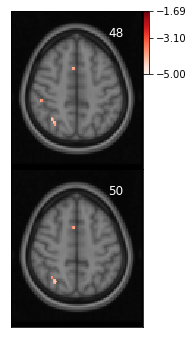

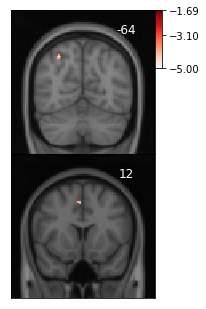

In [30]:
fig, axes = plot_slices(masked, clr2_thr, get_slices(clr2_peaks, axis="z", max_num=9), axial, figsize=2)
fig.subplots_adjust(wspace=0, hspace=0, top=1, bottom=0, left=0, right=1)

fig, axes = plot_slices(masked, clr2_thr, get_slices(clr2_peaks, axis="y", max_num=9), coronal, figsize=2)
fig.subplots_adjust(wspace=0, hspace=0, top=1, bottom=0, left=0, right=1)

In [31]:
# Number of voxels overlap clr1 and clr2
clr1 = nib.load(os.path.join(post, "clr1_masked.nii.gz")).get_data()
clr2 = nib.load(os.path.join(post, "clr2_masked.nii.gz")).get_data()
((clr2 < clr2_zthr) & (clr1 < clr1_zthr)).sum()

48

In [32]:
d = np.zeros(clr2.shape)
d[(clr2 < clr2_zthr) & (clr1 < clr1_zthr)] = 5

img = nib.Nifti1Image(d, nib.load(os.path.join(post, "clr1_masked.nii.gz")).affine)

In [33]:
nib.save(img, os.path.join(root, "data", "output", "postprocessing", "clr12_overlap.nii.gz"))

In [34]:
# Number significant voxels in clr2
(clr2 < clr2_zthr).sum()

54

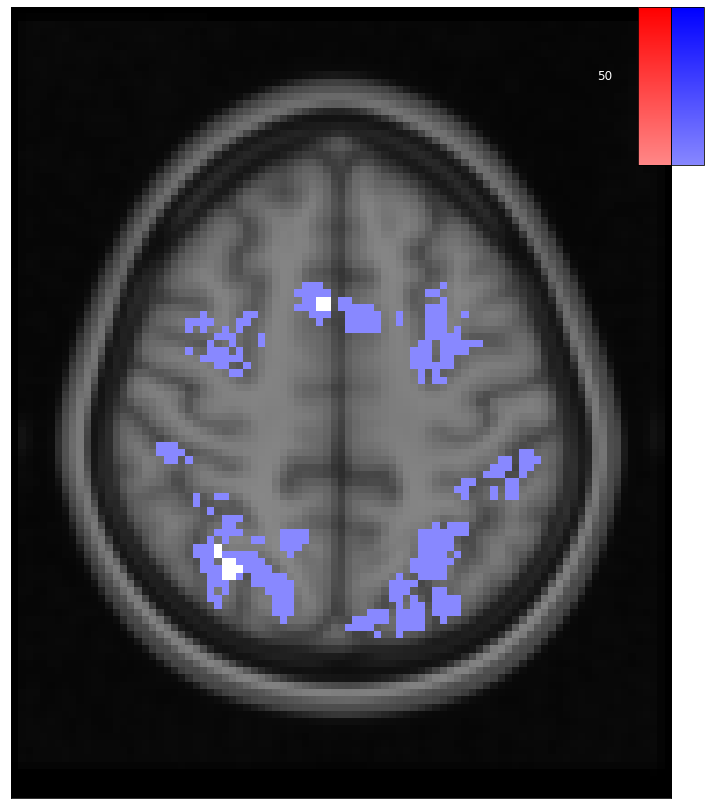

In [38]:
ncols = 1
slices = get_slices(clr2_peaks, max_num=1)
nrows = int(np.ceil(len(slices) / ncols))
idx = [ slice(None), slice(None), slice(None)]
idx[axial] = 50
size = np.array([ncols, nrows]) / np.rot90(mni[tuple(idx)]).shape * np.mean(np.rot90(mni[tuple(idx)]).shape) * 10
y, x = size

fig, axes = create_subplots(len(slices), ncols=ncols, figsize=(y, x))

for i, peak in enumerate(slices):
    idx[axial] = peak
   
    clr1 = np.rot90(nib.load(os.path.join(post, "clr1_masked.nii.gz")).get_data())[tuple(idx)]
    clr2 = np.rot90(nib.load(os.path.join(post, "clr2_masked.nii.gz")).get_data())[tuple(idx)]

    masked_clr1 = np.ma.masked_array(clr1, clr1 > clr1_zthr)
    masked_clr2 = np.ma.masked_array(clr2, clr2 > clr2_zthr)
    overlap = np.ma.masked_array(clr2, ((clr2 < clr2_zthr) & (clr1 < clr1_zthr)) == 0)
    
    # MNI
    axes[i].imshow(np.rot90(mni[tuple(idx)]), cmap=dark)
    base = np.rot90(base_mask[tuple(idx)])
    
#     # Base
#     im0 = axes[i].imshow(
#         np.ma.masked_array(base, base == 0), 
#         cmap=darkgray,
#         aspect=1, 
#         interpolation="nearest",
#         vmax=-1.69,
#         vmin=-5
#     )
    
    # Clr 1
    im1 = axes[i].imshow(
        masked_clr1, 
        cmap=darkblue,
        aspect=1, 
        interpolation="nearest",
        vmax=0,
        vmin=0
    )
    
    # Clr 2
    im2 = axes[i].imshow(
        masked_clr2, 
        cmap=darkred,
        aspect=1, 
        interpolation="nearest",
        vmax=-1.69,
        vmin=-5
    )

    # Clr 2
    im3 = axes[i].imshow(
        overlap,
        cmap=white,
        aspect=1, 
        interpolation="nearest",
        vmax=-1.69,
        vmin=-5,
        alpha=1,
    )
    
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    axes[i].set_title("%d" % (index2mni((peak, peak, peak))[axial]), color="white", x=.9, y=.9)

fig.subplots_adjust(wspace=0, hspace=0, top=1, bottom=0, left=0, right=1)

cbar_ax = fig.add_axes([1, .8, .05, .2])
fig.colorbar(im1, cax=cbar_ax, ticks=[-1.69, -3.1, -5])

cbar_ax = fig.add_axes([.95, .8, .05, .2])
_ = fig.colorbar(im2, cax=cbar_ax, ticks=[])

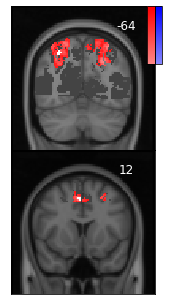

In [40]:
ncols = 1
nrows = int(np.ceil(len(clr2_peaks) / ncols))
idx = [ slice(None), slice(None), slice(None)]
idx[coronal] = 50
size = np.array([ncols, nrows]) / np.rot90(mni[tuple(idx)]).shape * np.mean(np.rot90(mni[tuple(idx)]).shape) * 2
y, x = size

fig, axes = create_subplots(len(clr2_peaks), ncols=ncols, figsize=(y, x))

for i, peak in enumerate(get_slices(clr2_peaks, axis="y")):
    idx[coronal] = peak

    clr1 = np.rot90(nib.load(os.path.join(post, "clr1_masked.nii.gz")).get_data()[tuple(idx)])
    clr2 = np.rot90(nib.load(os.path.join(post, "clr2_masked.nii.gz")).get_data()[tuple(idx)])

    masked_clr1 = np.ma.masked_array(clr1, clr1 > clr1_zthr)
    masked_clr2 = np.ma.masked_array(clr2, clr2 > clr2_zthr)
    overlap = np.ma.masked_array(clr2, ((clr2 < clr2_zthr) & (clr1 < clr1_zthr)) == 0)
        
    # MNI
    axes[i].imshow(np.rot90(mni[tuple(idx)]), cmap=dark)

    base = np.rot90(base_mask[tuple(idx)])
    # Base
    axes[i].imshow(
        np.ma.masked_array(base, base == 0), 
        cmap=darkgray,
        interpolation="nearest",
        vmax=-1.69,
        vmin=-5,
    )
    
    # Clr 1
    axes[i].imshow(
        masked_clr1, 
        cmap=darkred,
        interpolation="nearest",
        vmax=-1.69,
        vmin=-5,
        alpha=1,
    )
    
    # Clr 2
    axes[i].imshow(
        masked_clr2,
        cmap=darkblue,
        interpolation="nearest",
        vmax=-1.69,
        vmin=-5,
        alpha=1,
    )
    
    # Clr 2
    axes[i].imshow(
        overlap,
        cmap=white,
        interpolation="nearest",
        vmax=-1.69,
        vmin=-5,
        alpha=1,
    )

    axes[i].set_xticks([])
    axes[i].set_yticks([])
    axes[i].set_title("%d" % ( index2mni((peak, peak, peak))[coronal] ), color="white", y=.8, x=.8)
    

fig.subplots_adjust(wspace=0, hspace=0, top=1, bottom=0, left=0, right=1)
cbar_ax = fig.add_axes([1, .8, .05, .2]) 
fig.colorbar(im1, cax=cbar_ax, ticks=[-1.69, -3.1, -5])

cbar_ax = fig.add_axes([.95, .8, .05, .2])
fig.colorbar(im2, cax=cbar_ax, ticks=[])

436 427 436


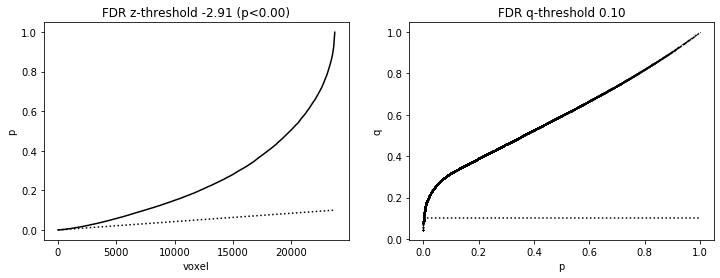

In [41]:
clr1_mask = nib.load(contrasts["clr_lag1_priming"]).get_data() < clr1_thr
clr1_mask *= base_mask

zstat = nib.load(contrasts["clr_lag2_priming"]).get_data()
clr2_masked = zstat * clr1_mask.astype(int)
aff = nib.load(contrasts["clr_lag2_priming"]).affine
save_nii(clr2_masked, aff, os.path.join(post, "clr2_masked.nii.gz"))

qval = .1
clr2_thr, clr2_zthr, pvals, thrline, pcor, padj = fdr(zstat, q=qval, mask=clr1_mask, invert_zscores=True)

fig, axes = plt.subplots(ncols=2, figsize=(12, 4))
axes[0].plot(pvals, "k-")
axes[0].plot(thrline, "k:")
axes[0].set_xlabel("voxel")
axes[0].set_ylabel("p")
axes[1].plot(pvals, padj, "k.", markersize=.5)
axes[1].hlines(qval, xmin=0, xmax=1, linestyle=":", color="#000000")
axes[1].set_xlabel("p")
axes[1].set_ylabel("q")
_ = axes[0].set_title("FDR z-threshold %.2f (p<%.2f)" % (clr2_zthr, clr2_thr))
_ = axes[1].set_title("FDR q-threshold %.2f" % qval)

print(
    (pvals <= clr2_thr).sum(),
    (pcor <= qval).sum(),
    (padj <= qval).sum()
)

In [42]:
clr2_peaks = find_peaks( in_file=os.path.join( post, "clr2_masked.nii.gz" ), threshold=clr2_zthr, find_min=True, args="--minextent=8")

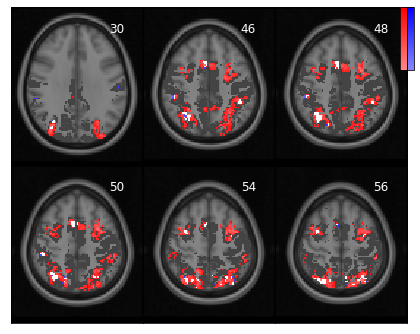

In [43]:
ncols = 3
peaks = get_slices(clr2_peaks, axis="z")
nrows = int(np.ceil(len(peaks) / ncols))
idx = [ slice(None), slice(None), slice(None)]
idx[axial] = 50
size = np.array([ncols, nrows]) / np.rot90(mni[tuple(idx)]).shape * np.mean(np.rot90(mni[tuple(idx)]).shape) * 2
y, x = size

fig, axes = create_subplots(len(peaks), ncols=ncols, figsize=(y, x))

for i, peak in enumerate(peaks):
    idx[axial] = peak

    clr1 = np.rot90(nib.load(os.path.join(post, "clr1_masked.nii.gz")).get_data()[tuple(idx)])
    clr2 = np.rot90(nib.load(os.path.join(post, "clr2_masked.nii.gz")).get_data()[tuple(idx)])

    masked_clr1 = np.ma.masked_array(clr1, clr1 > clr1_zthr)
    masked_clr2 = np.ma.masked_array(clr2, clr2 > clr2_zthr)
    overlap = np.ma.masked_array(clr2, ((clr2 < clr2_zthr) & (clr1 < clr1_zthr)) == 0)
        
    # MNI
    axes[i].imshow(np.rot90(mni[tuple(idx)]), cmap=dark)

    base = np.rot90(base_mask[tuple(idx)])
    # Base
    axes[i].imshow(
        np.ma.masked_array(base, base == 0), 
        cmap=darkgray,
        interpolation="nearest",
        vmax=-1.69,
        vmin=-5,
    )
    
    # Clr 1
    axes[i].imshow(
        masked_clr1, 
        cmap=darkred,
        interpolation="nearest",
        vmax=-1.69,
        vmin=-5,
        alpha=1,
    )
    
    # Clr 2
    axes[i].imshow(
        masked_clr2,
        cmap=darkblue,
        interpolation="nearest",
        vmax=-1.69,
        vmin=-5,
        alpha=1,
    )
    
    # Clr 2
    axes[i].imshow(
        overlap,
        cmap=white,
        interpolation="nearest",
        vmax=-1.69,
        vmin=-5,
        alpha=1,
    )

    axes[i].set_xticks([])
    axes[i].set_yticks([])
    axes[i].set_title("%d" % ( index2mni((peak, peak, peak))[axial] ), color="white", y=.8, x=.8)
    

fig.subplots_adjust(wspace=0, hspace=0, top=1, bottom=0, left=0, right=1)

cbar_width = (1 / ncols) * .05
cbar_height = (1 / nrows) * .4

cbar_ax = fig.add_axes([1, 1-cbar_height, cbar_width, cbar_height])
fig.colorbar(im1, cax=cbar_ax, ticks=[-1.69, -3.1, -5])

cbar_ax = fig.add_axes([1-cbar_width, 1-cbar_height, cbar_width, cbar_height])
fig.colorbar(im2, cax=cbar_ax, ticks=[])

## Location lag 1

431 233 431


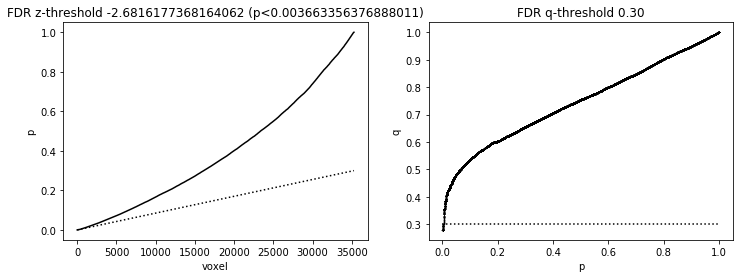

In [44]:
zstat = nib.load(contrasts["loc_lag1_priming"]).get_data()

qval = .3
loc1_thr, loc1_zthr, pvals, thrline, pcor, padj = fdr(zstat, q=qval, mask=base_mask, invert_zscores=True)

loc1_masked = zstat * base_mask.astype(int)
aff = nib.load(contrasts["loc_lag1_priming"]).affine
save_nii(loc1_masked, aff, os.path.join(post, "loc1_masked.nii.gz"))

loc1_zthr = -3.1 if not loc1_zthr else loc1_zthr
masked = np.ma.masked_array(loc1_masked, loc1_masked > loc1_zthr)
masked2 = masked * masked.mask

fig, axes = plt.subplots(ncols=2, figsize=(12, 4))
axes[0].plot(pvals, "k-")
axes[0].plot(thrline, "k:")
axes[0].set_xlabel("voxel")
axes[0].set_ylabel("p")
axes[1].plot(pvals, padj, "k.", markersize=.5)
axes[1].hlines(qval, xmin=0, xmax=1, linestyle=":", color="#000000")
axes[1].set_xlabel("p")
axes[1].set_ylabel("q")
_ = axes[0].set_title("FDR z-threshold %s (p<%s)" % (str(loc1_zthr), str(loc1_thr)))
_ = axes[1].set_title("FDR q-threshold %.2f" % qval)

print(
    (pvals <= loc1_thr).sum(),
    (pcor <= qval).sum(),
    (padj <= qval).sum()
)

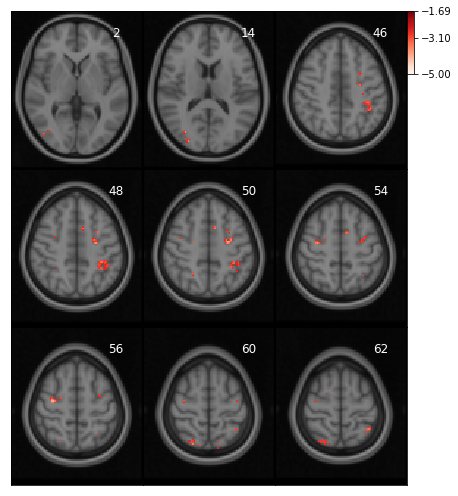

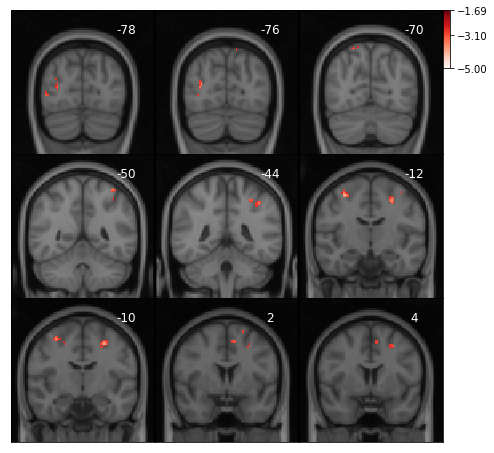

In [45]:
loc1_peaks = find_peaks( in_file=os.path.join( post, "loc1_masked.nii.gz" ), threshold=loc1_zthr, find_min=True, args="--minextent=8")

fig, axes = plot_slices(masked, loc1_thr,  get_slices(loc1_peaks, axis="z", max_num=9), axial, ncols=3, figsize=2)
fig.subplots_adjust(wspace=0, hspace=0, top=1, bottom=0, left=0, right=1)

fig, axes = plot_slices(masked, loc1_thr,  get_slices(loc1_peaks, axis="y", max_num=9), coronal, ncols=3, figsize=2)
fig.subplots_adjust(wspace=0, hspace=0, top=1, bottom=0, left=0, right=1)

## Location lag 2

2245 2245 2245


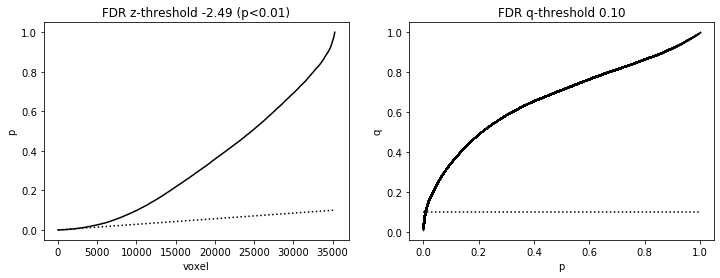

In [46]:
zstat = nib.load(contrasts["loc_lag2_priming"]).get_data()
loc2_masked = zstat * base_mask.astype(int)
aff = nib.load(contrasts["loc_lag2_priming"]).affine
save_nii(loc2_masked, aff, os.path.join(post, "loc2_masked.nii.gz"))

qval = .1
loc2_thr, loc2_zthr, pvals, thrline, pcor, padj = fdr(zstat, q=qval, mask=base_mask, invert_zscores=True)

fig, axes = plt.subplots(ncols=2, figsize=(12, 4))
axes[0].plot(pvals, "k-")
axes[0].plot(thrline, "k:")
axes[0].set_xlabel("voxel")
axes[0].set_ylabel("p")
axes[1].plot(pvals, padj, "k.", markersize=.5)
axes[1].hlines(qval, xmin=0, xmax=1, linestyle=":", color="#000000")
axes[1].set_xlabel("p")
axes[1].set_ylabel("q")
_ = axes[0].set_title("FDR z-threshold %.2f (p<%.2f)" % (loc2_zthr, loc2_thr))
_ = axes[1].set_title("FDR q-threshold %.2f" % qval)

print(
    (pvals <= loc2_thr).sum(),
    (pcor <= qval).sum(),
    (padj <= qval).sum()
)

masked = np.ma.masked_array(loc2_masked, loc2_masked > loc2_zthr)
masked2 = masked * masked.mask.astype(int)

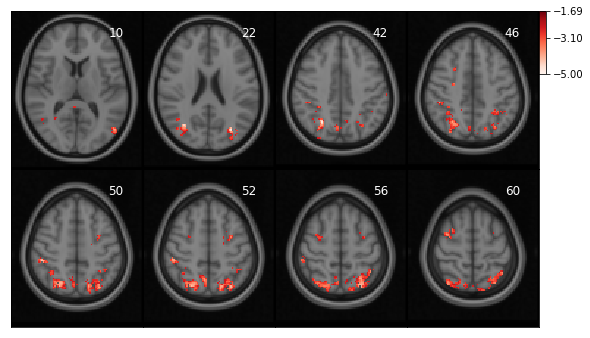

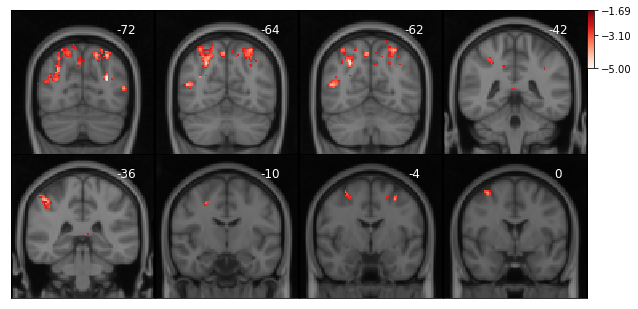

In [47]:
loc2_peaks = find_peaks( in_file=os.path.join( post, "loc2_masked.nii.gz" ), threshold=loc2_zthr, find_min=True, args="--minextent=8")

fig, axes = plot_slices(masked, loc2_thr, loc2_peaks.z.sort_values().unique(), axial, ncols=4, figsize=2)
fig.subplots_adjust(wspace=0, hspace=0, top=1, bottom=0, left=0, right=1)

fig, axes = plot_slices(masked, loc2_thr, loc2_peaks.y.sort_values().unique(), coronal, ncols=4, figsize=2)
fig.subplots_adjust(wspace=0, hspace=0, top=1, bottom=0, left=0, right=1)


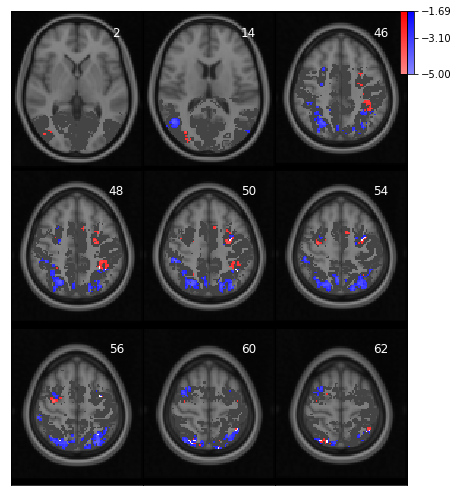

In [48]:
n = len(loc1_peaks.z.sort_values().unique())
ncols = 3
nrows = int(np.ceil(n / ncols))
idx = [ slice(None), slice(None), slice(None)]
idx[axial] = 50
size = np.array([ncols, nrows]) / np.rot90(mni[tuple(idx)]).shape * np.mean(np.rot90(mni[tuple(idx)]).shape) * 2
y, x = size

fig, axes = create_subplots(n, ncols=ncols, figsize=(y, x))

for i, peak in enumerate(loc1_peaks.z.sort_values().unique()):
    idx[axial] = peak
    
    loc1 = np.rot90(nib.load(os.path.join(post, "loc1_masked.nii.gz")).get_data()[tuple(idx)])
    loc2 = np.rot90(nib.load(os.path.join(post, "loc2_masked.nii.gz")).get_data()[tuple(idx)])

    masked_loc1 = np.ma.masked_array(loc1, loc1 > loc1_zthr)
    masked_loc2 = np.ma.masked_array(loc2, loc2 > loc2_zthr)
    overlap = np.ma.masked_array(loc2, ((loc2 < loc2_zthr) & (loc1 < loc1_zthr)) == 0)
    
    # MNI
    axes[i].imshow(np.rot90(mni[tuple(idx)]), cmap=dark)
    
    base = np.rot90(base_mask[tuple(idx)])
    
    # Base
    im0 = axes[i].imshow(
        np.ma.masked_array(base, base == 0), 
        cmap=darkgray,
        aspect=1, 
        interpolation="nearest",
        vmax=-1.69,
        vmin=-5
    )
    
    # Clr 2
    im1 = axes[i].imshow(
        masked_loc2, 
        cmap=darkblue,
        aspect=1, 
        interpolation="nearest",
        vmax=-1.69,
        vmin=-5
    )
    
    # Clr 1
    im2 = axes[i].imshow(
        masked_loc1, 
        cmap=darkred,
        aspect=1, 
        interpolation="nearest",
        vmax=-1.69,
        vmin=-5
    )
    
    # Clr 2
    axes[i].imshow(
        overlap,
        cmap=white,
        aspect=1, 
        interpolation="nearest",
        vmax=-1.69,
        vmin=-5,
        alpha=1,
    )
    
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    axes[i].set_title("%d" % (index2mni((peak, peak, peak))[axial]), x=.8, y=.8, color="white")

fig.subplots_adjust(wspace=0, hspace=0, top=1, bottom=0, left=0, right=1)

cbar_width = (1 / ncols) * .05
cbar_height = (1 / nrows) * .4

cbar_ax = fig.add_axes([1, 1-cbar_height, cbar_width, cbar_height])
fig.colorbar(im1, cax=cbar_ax, ticks=[-1.69, -3.1, -5])

cbar_ax = fig.add_axes([1-cbar_width, 1-cbar_height, cbar_width, cbar_height])
fig.colorbar(im2, cax=cbar_ax, ticks=[])

In [49]:
# Number of voxels overlap between clr1 and loc2
loc1 = nib.load(os.path.join(post, "loc1_masked.nii.gz")).get_data()
loc2 = nib.load(os.path.join(post, "loc2_masked.nii.gz")).get_data()
((loc2 < loc2_zthr) & (loc1 < loc1_zthr)).sum()

44

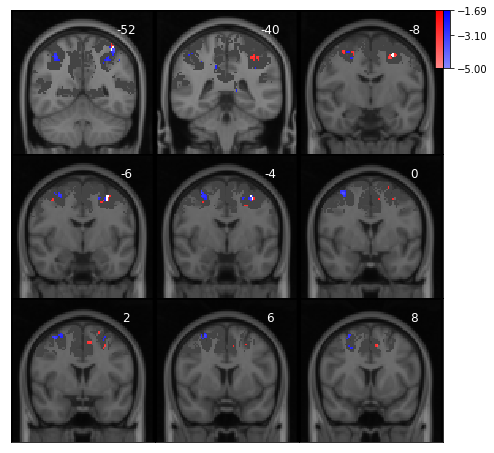

In [50]:
n = len(loc1_peaks.z.sort_values().unique())
ncols = 3
nrows = int(np.ceil(n / ncols))
idx = [ slice(None), slice(None), slice(None)]
idx[coronal] = 50
size = np.array([ncols, nrows]) / np.rot90(mni[tuple(idx)]).shape * np.mean(np.rot90(mni[tuple(idx)]).shape) * 2
y, x = size

fig, axes = create_subplots(n, ncols=ncols, figsize=(y, x))

for i, peak in enumerate(loc1_peaks.z.sort_values().unique()):
    idx[coronal] = peak
    
    loc1 = np.rot90(nib.load(os.path.join(post, "loc1_masked.nii.gz")).get_data()[tuple(idx)])
    loc2 = np.rot90(nib.load(os.path.join(post, "loc2_masked.nii.gz")).get_data()[tuple(idx)])

    masked_loc1 = np.ma.masked_array(loc1, loc1 > loc1_zthr)
    masked_loc2 = np.ma.masked_array(loc2, loc2 > loc2_zthr)
    overlap = np.ma.masked_array(loc2, ((loc2 < loc2_zthr) & (loc1 < loc1_zthr)) == 0)
    
    # MNI
    axes[i].imshow(np.rot90(mni[tuple(idx)]), cmap=dark)
    
    base = np.rot90(base_mask[tuple(idx)])
    
    # Base
    im0 = axes[i].imshow(
        np.ma.masked_array(base, base == 0), 
        cmap=darkgray,
        aspect=1, 
        interpolation="nearest",
        vmax=-1.69,
        vmin=-5
    )
    
    # Clr 2
    im1 = axes[i].imshow(
        masked_loc2, 
        cmap=darkblue,
        aspect=1, 
        interpolation="nearest",
        vmax=-1.69,
        vmin=-5
    )
    
    # Clr 1
    im2 = axes[i].imshow(
        masked_loc1, 
        cmap=darkred,
        aspect=1, 
        interpolation="nearest",
        vmax=-1.69,
        vmin=-5
    )
    
    # Clr 2
    axes[i].imshow(
        overlap,
        cmap=white,
        aspect=1, 
        interpolation="nearest",
        vmax=-1.69,
        vmin=-5,
        alpha=1,
    )
    
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    axes[i].set_title("%d" % (index2mni((peak, peak, peak))[coronal]), x=.8, y=.8, color="white")

fig.subplots_adjust(wspace=0, hspace=0, top=1, bottom=0, left=0, right=1)

cbar_width = (1 / ncols) * .05
cbar_height = (1 / nrows) * .4

cbar_ax = fig.add_axes([1, 1-cbar_height, cbar_width, cbar_height])
fig.colorbar(im1, cax=cbar_ax, ticks=[-1.69, -3.1, -5])

cbar_ax = fig.add_axes([1-cbar_width, 1-cbar_height, cbar_width, cbar_height])
fig.colorbar(im2, cax=cbar_ax, ticks=[])

## Overlap between color lag 1 and location lag 1

In [51]:
loc1 = nib.load(os.path.join(post, "loc1_masked.nii.gz")).get_data()
clr1 = nib.load(os.path.join(post, "clr1_masked.nii.gz")).get_data()
overlap = (clr1 < clr1_zthr) & (loc1 < loc1_zthr)
overlap.sum()

196

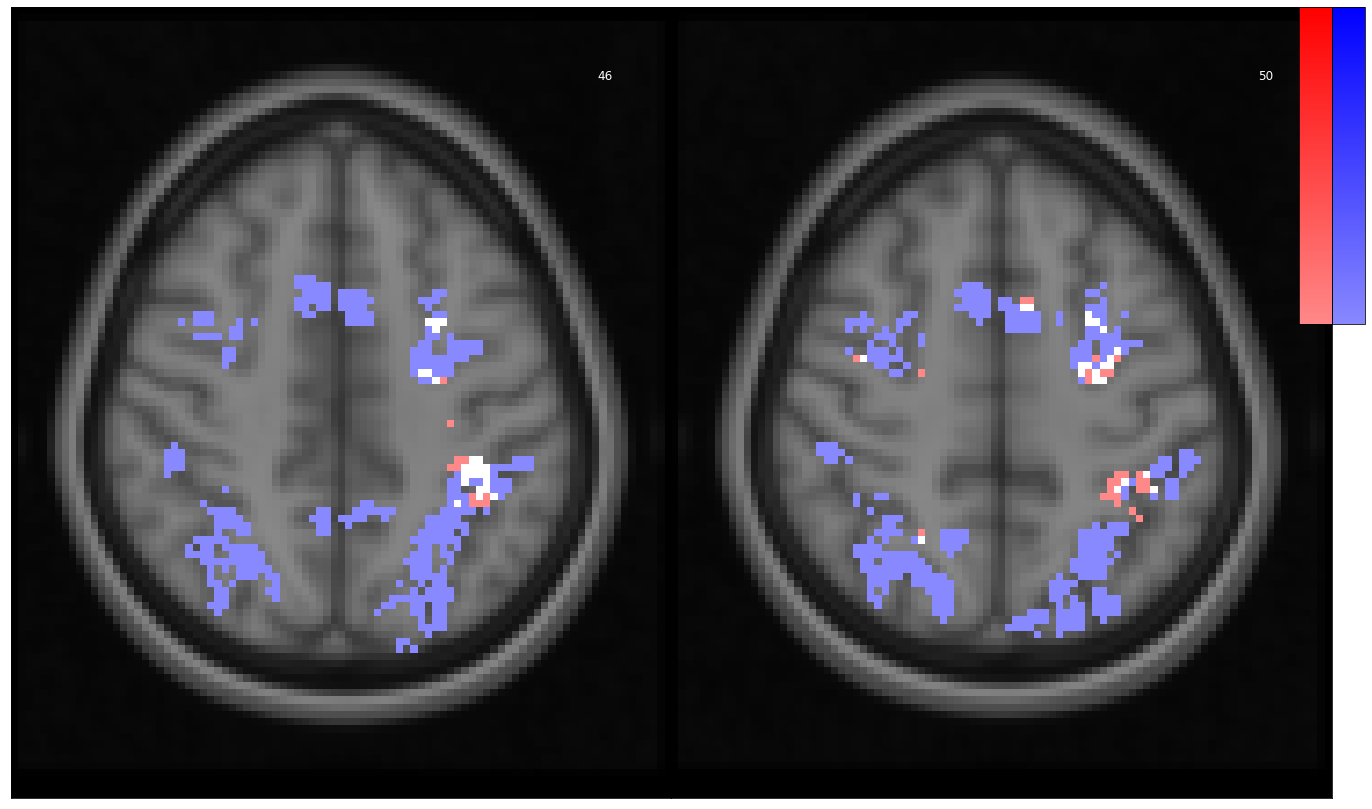

In [52]:
slices = get_slices(loc1_peaks, axis="z", max_num=2)
n = len(slices)
ncols = 2
nrows = int(np.ceil(n / ncols))
idx = [ slice(None), slice(None), slice(None)]
idx[axial] = 50
size = np.array([ncols, nrows]) / np.rot90(mni[tuple(idx)]).shape * np.mean(np.rot90(mni[tuple(idx)]).shape) * 10
y, x = size

fig, axes = create_subplots(n, ncols=ncols, figsize=(y, x))

for i, peak in enumerate(slices):
    idx[axial] = peak
    
    loc1 = np.rot90(nib.load(os.path.join(post, "loc1_masked.nii.gz")).get_data()[tuple(idx)])
    clr1 = np.rot90(nib.load(os.path.join(post, "clr1_masked.nii.gz")).get_data()[tuple(idx)])

    masked_loc1 = np.ma.masked_array(loc1, loc1 > loc1_zthr)
    masked_clr1 = np.ma.masked_array(clr1, clr1 > clr1_zthr)
    
    overlap = np.ma.masked_array(clr1, ((clr1 < clr1_zthr) & (loc1 < loc1_zthr)) == 0)
    
    # MNI
    axes[i].imshow(np.rot90(mni[tuple(idx)]), cmap=dark)
    
    base = np.rot90(base_mask[tuple(idx)])
    
    #     # Base
    #     im0 = axes[i].imshow(
    #         np.ma.masked_array(base, base == 0), 
    #         cmap=darkgray,
    #         aspect=1, 
    #         interpolation="nearest",
    #         vmax=-0,
    #         vmin=-0 
    #     )  
     
    # Clr 2
    im1 = axes[i].imshow(
        masked_clr1, 
        cmap=darkblue,
        aspect=1, 
        interpolation="nearest",
        vmax=-0,
        vmin=-0
    )
    
    # Clr 1
    im2 = axes[i].imshow(
        masked_loc1, 
        cmap=darkred,
        aspect=1, 
        interpolation="nearest",
        vmax=-0,
        vmin=-0
    )
    
    # Clr 2
    axes[i].imshow(
        overlap,
        cmap=white,
        aspect=1, 
        interpolation="nearest",
        vmax=-1.69,
        vmin=-5,
        alpha=1,
    )
    
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    axes[i].set_title("%d" % (index2mni((peak, peak, peak))[axial]), x=.9, y=.9, color="white")

fig.subplots_adjust(wspace=0, hspace=0, top=1, bottom=0, left=0, right=1)

cbar_width = (1 / ncols) * .05
cbar_height = (1 / nrows) * .4

cbar_ax = fig.add_axes([1, 1-cbar_height, cbar_width, cbar_height])
fig.colorbar(im1, cax=cbar_ax, ticks=[-1.69, -3.1, -5])

cbar_ax = fig.add_axes([1-cbar_width, 1-cbar_height, cbar_width, cbar_height])
fig.colorbar(im2, cax=cbar_ax, ticks=[])

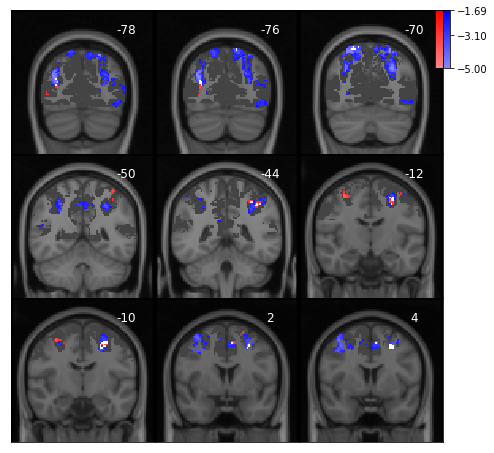

In [53]:
n = 9
ncols = 3
nrows = int(np.ceil(n / ncols))
idx = [ slice(None), slice(None), slice(None)]
idx[coronal] = 50
size = np.array([ncols, nrows]) / np.rot90(mni[tuple(idx)]).shape * np.mean(np.rot90(mni[tuple(idx)]).shape) * 2
y, x = size

fig, axes = create_subplots(n, ncols=ncols, figsize=(y, x))

for i, peak in enumerate(get_slices(loc1_peaks, axis="y", max_num=9)):
    idx[coronal] = peak
    
    loc1 = np.rot90(nib.load(os.path.join(post, "loc1_masked.nii.gz")).get_data()[tuple(idx)])
    clr1 = np.rot90(nib.load(os.path.join(post, "clr1_masked.nii.gz")).get_data()[tuple(idx)])

    masked_loc1 = np.ma.masked_array(loc1, loc1 > loc1_zthr)
    masked_clr1 = np.ma.masked_array(clr1, clr1 > clr1_zthr)
    
    overlap = np.ma.masked_array(clr1, ((clr1 < clr1_zthr) & (loc1 < loc1_zthr)) == 0)
    
    # MNI
    axes[i].imshow(np.rot90(mni[tuple(idx)]), cmap=dark)    
    base = np.rot90(base_mask[tuple(idx)])
    
    # Base
    im0 = axes[i].imshow(
        np.ma.masked_array(base, base == 0), 
        cmap=darkgray,
        aspect=1, 
        interpolation="nearest",
        vmax=-1.69,
        vmin=-5 
    )  
     
    # Clr 2
    im1 = axes[i].imshow(
        masked_clr1, 
        cmap=darkblue,
        aspect=1, 
        interpolation="nearest",
        vmax=-1.69,
        vmin=-5
    )
    
    # Clr 1
    im2 = axes[i].imshow(
        masked_loc1, 
        cmap=darkred,
        aspect=1, 
        interpolation="nearest",
        vmax=-1.69,
        vmin=-5
    )
    
    # Clr 2
    axes[i].imshow(
        overlap,
        cmap=white,
        aspect=1, 
        interpolation="nearest",
        vmax=-1.69,
        vmin=-5,
        alpha=1,
    )
    
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    axes[i].set_title("%d" % (index2mni((peak, peak, peak))[coronal]), x=.8, y=.8, color="white")

fig.subplots_adjust(wspace=0, hspace=0, top=1, bottom=0, left=0, right=1)

cbar_width = (1 / ncols) * .05
cbar_height = (1 / nrows) * .4

cbar_ax = fig.add_axes([1, 1-cbar_height, cbar_width, cbar_height])
fig.colorbar(im1, cax=cbar_ax, ticks=[-1.69, -3.1, -5])

cbar_ax = fig.add_axes([1-cbar_width, 1-cbar_height, cbar_width, cbar_height])
fig.colorbar(im2, cax=cbar_ax, ticks=[])

# Overlap between color lag 1 and location lag 2

In [54]:
loc2 = nib.load(os.path.join(post, "loc2_masked.nii.gz")).get_data()
clr1 = nib.load(os.path.join(post, "clr1_masked.nii.gz")).get_data()
overlap = (clr1 < clr1_zthr) & (loc2 < loc2_zthr)
overlap.sum()

1263

In [55]:
(loc2[base_mask] < loc2_zthr).sum()

2244

In [56]:
peaks = get_slices(loc2_peaks, axis="z", max_num=2)

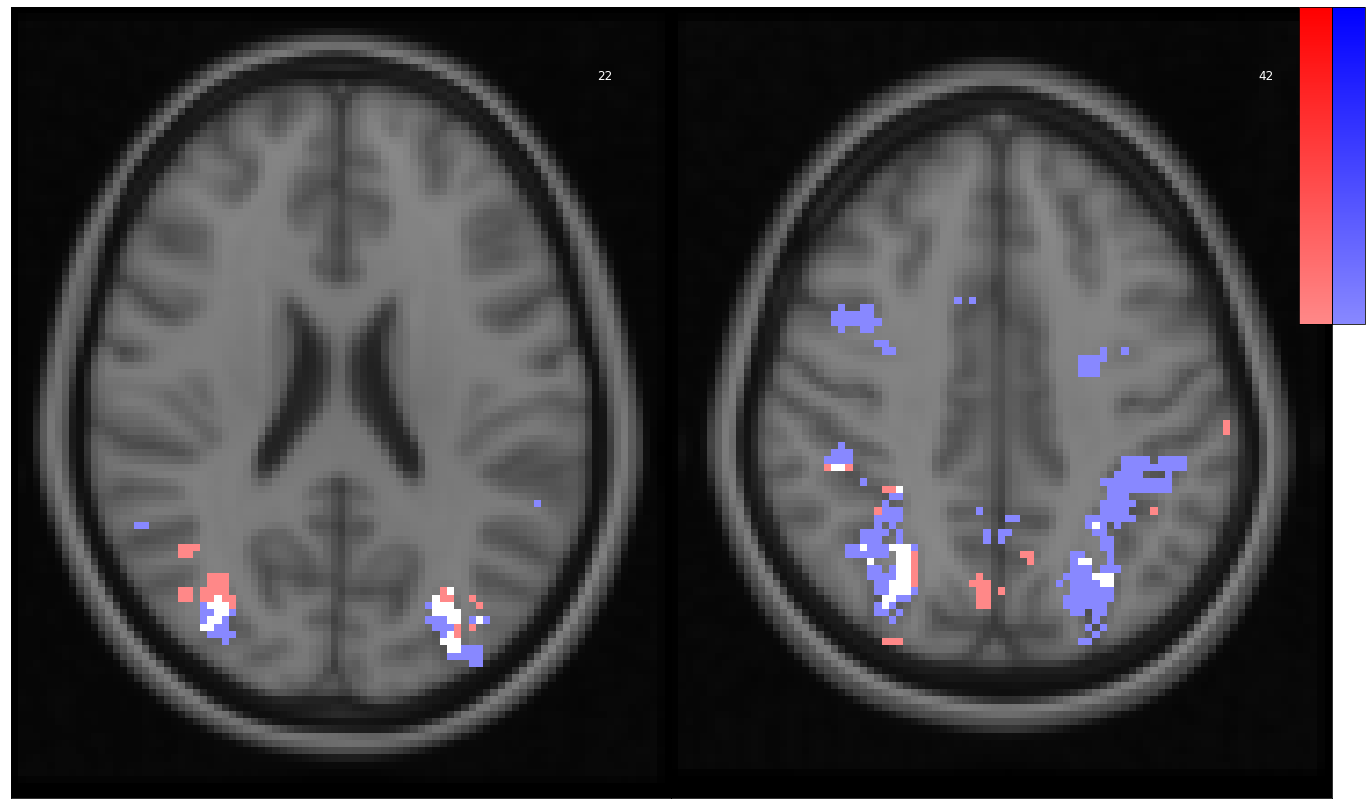

In [57]:
n = len(peaks)
ncols = 2
nrows = int(np.ceil(n / ncols))
idx = [ slice(None), slice(None), slice(None)]
idx[axial] = 50
size = np.array([ncols, nrows]) / np.rot90(mni[tuple(idx)]).shape * np.mean(np.rot90(mni[tuple(idx)]).shape) * 10
y, x = size

fig, axes = create_subplots(n, ncols=ncols, figsize=(y, x))

for i, peak in enumerate(peaks):
    idx[axial] = peak
    
    loc2 = np.rot90(nib.load(os.path.join(post, "loc2_masked.nii.gz")).get_data()[tuple(idx)])
    clr1 = np.rot90(nib.load(os.path.join(post, "clr1_masked.nii.gz")).get_data()[tuple(idx)])

    masked_loc2 = np.ma.masked_array(loc2, loc2 > loc2_zthr)
    masked_clr1 = np.ma.masked_array(clr1, clr1 > clr1_zthr)
    
    overlap = np.ma.masked_array(clr1, ((clr1 < clr1_zthr) & (loc2 < loc2_zthr)) == 0)
    
    # MNI
    axes[i].imshow(np.rot90(mni[tuple(idx)]), cmap=dark)
    
    base = np.rot90(base_mask[tuple(idx)])
    
    #     # Base
    #     im0 = axes[i].imshow(
    #         np.ma.masked_array(base, base == 0), 
    #         cmap=darkgray,
    #         aspect=1, 
    #         interpolation="nearest",
    #         vmax=-1.69,
    #         vmin=-5 
    #     )  
     
    # Clr 2
    im1 = axes[i].imshow(
        masked_clr1, 
        cmap=darkblue,
        aspect=1, 
        interpolation="nearest",
        vmax=0,
        vmin=0
    )
    
    # Clr 1
    im2 = axes[i].imshow(
        masked_loc2, 
        cmap=darkred,
        aspect=1, 
        interpolation="nearest",
        vmax=0,
        vmin=0
    )
    
    # Clr 2
    axes[i].imshow(
        overlap,
        cmap=white,
        aspect=1, 
        interpolation="nearest",
        vmax=-1.69,
        vmin=-5,
        alpha=1,
    )
    
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    axes[i].set_title("%d" % (index2mni((peak, peak, peak))[axial]), x=.9, y=.9, color="white")

fig.subplots_adjust(wspace=0, hspace=0, top=1, bottom=0, left=0, right=1)

cbar_width = (1 / ncols) * .05
cbar_height = (1 / nrows) * .4

cbar_ax = fig.add_axes([1, 1-cbar_height, cbar_width, cbar_height])
fig.colorbar(im1, cax=cbar_ax, ticks=[-1.69, -3.1, -5])

cbar_ax = fig.add_axes([1-cbar_width, 1-cbar_height, cbar_width, cbar_height])
fig.colorbar(im2, cax=cbar_ax, ticks=[])

IndexError: list index out of range

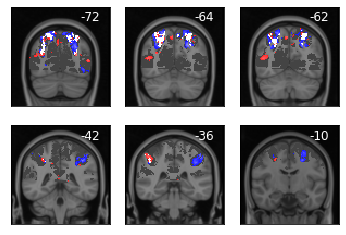

In [58]:
n = 6 #len(loc2_peaks.y.sort_values().unique())
ncols = 3
nrows = int(np.ceil(n / ncols))
idx = [ slice(None), slice(None), slice(None)]
idx[coronal] = 50
size = np.array([ncols, nrows]) / np.rot90(mni[tuple(idx)]).shape * np.mean(np.rot90(mni[tuple(idx)]).shape) * 2
y, x = size

fig, axes = create_subplots(n, ncols=ncols, figsize=(y, x))

for i, peak in enumerate(loc2_peaks.y.sort_values().unique()):
    idx[coronal] = peak
    
    loc2 = np.rot90(nib.load(os.path.join(post, "loc2_masked.nii.gz")).get_data()[tuple(idx)])
    clr1 = np.rot90(nib.load(os.path.join(post, "clr1_masked.nii.gz")).get_data()[tuple(idx)])

    masked_loc2 = np.ma.masked_array(loc2, loc2 > loc2_zthr)
    masked_clr1 = np.ma.masked_array(clr1, clr1 > clr1_zthr)
    
    overlap = np.ma.masked_array(clr1, ((clr1 < clr1_zthr) & (loc2 < loc2_zthr)) == 0)
    
    # MNI
    axes[i].imshow(np.rot90(mni[tuple(idx)]), cmap=dark)
    
    base = np.rot90(base_mask[tuple(idx)])
    
    # Base
    im0 = axes[i].imshow(
        np.ma.masked_array(base, base == 0), 
        cmap=darkgray,
        aspect=1, 
        interpolation="nearest",
        vmax=-1.69,
        vmin=-5 
    )  
     
    # Clr 2
    im1 = axes[i].imshow(
        masked_clr1, 
        cmap=darkblue,
        aspect=1, 
        interpolation="nearest",
        vmax=-1.69,
        vmin=-5
    )
    
    # Clr 1
    im2 = axes[i].imshow(
        masked_loc2, 
        cmap=darkred,
        aspect=1, 
        interpolation="nearest",
        vmax=-1.69,
        vmin=-5
    )
    
    # Clr 2
    axes[i].imshow(
        overlap,
        cmap=white,
        aspect=1, 
        interpolation="nearest",
        vmax=-1.69,
        vmin=-5,
        alpha=1,
    )
    
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    axes[i].set_title("%d" % (index2mni((peak, peak, peak))[coronal]), x=.8, y=.8, color="white")

fig.subplots_adjust(wspace=0, hspace=0, top=1, bottom=0, left=0, right=1)

cbar_width = (1 / ncols) * .05
cbar_height = (1 / nrows) * .4

cbar_ax = fig.add_axes([1, 1-cbar_height, cbar_width, cbar_height])
fig.colorbar(im1, cax=cbar_ax, ticks=[-1.69, -3.1, -5])

cbar_ax = fig.add_axes([1-cbar_width, 1-cbar_height, cbar_width, cbar_height])
fig.colorbar(im2, cax=cbar_ax, ticks=[])

## Clusters

In [59]:
# Cluster
rois_path = os.path.join(post, "clr1_clusters.nii.gz")
cluster = fsl.Cluster(
    threshold=clr1_zthr,
    in_file=os.path.join(post, "clr1_masked.nii.gz"),
    args="--minextent=8",
    out_index_file=rois_path,
    find_min=True)

cluster.run()

190815-15:28:39,820 nipype.interface INFO:
	 stdout 2019-08-15T15:28:39.820091:Cluster Index	Voxels	MAX	MAX X (vox)	MAX Y (vox)	MAX Z (vox)	COG X (vox)	COG Y (vox)	COG Z (vox)
190815-15:28:39,822 nipype.interface INFO:
	 stdout 2019-08-15T15:28:39.820091:14	1938	-5.88	57	28	65	58.6	31.1	58.1
190815-15:28:39,824 nipype.interface INFO:
	 stdout 2019-08-15T15:28:39.820091:13	1560	-5.86	27	25	48	30.6	29.1	57.9
190815-15:28:39,825 nipype.interface INFO:
	 stdout 2019-08-15T15:28:39.820091:12	547	-4.73	59	63	63	58.7	61.6	62.4
190815-15:28:39,827 nipype.interface INFO:
	 stdout 2019-08-15T15:28:39.820091:11	319	-4.69	27	63	66	27.4	62.9	62.1
190815-15:28:39,829 nipype.interface INFO:
	 stdout 2019-08-15T15:28:39.820091:10	122	-4.7	43	69	59	41.1	67.9	60.8
190815-15:28:39,830 nipype.interface INFO:
	 stdout 2019-08-15T15:28:39.820091:9	100	-3.45	66	27	33	66.9	26.4	32.3
190815-15:28:39,832 nipype.interface INFO:
	 stdout 2019-08-15T15:28:39.820091:8	91	-4.11	21	47	60	21.6	46.3	59.7
190815-15:28:3

# ROIs

In [60]:
# to_surface = freesurfer.SampleToSurface(
#     mni152reg=True,
#     target_subject='fsaverage',
#     subjects_dir=fs_dir,
#     cortex_mask=True,
#     sampling_method="average",
#     sampling_range=(0.2, 0.8, 0.1),
#     sampling_units="frac",
#     smooth_surf=0.0,
#     hemi="rh",
#     source_file=overlap_path)

In [62]:
# img = nib.load(rois_path)
# rois = img.get_data()
# rmin, rmax = rois.min(), rois.max()
# zstat = nib.load(contrasts["clr_lag2_priming"])

# new_img = np.zeros(zstat.shape)
# for i in range(rmin+1, rmax+1):
#     mask = (rois == i)     
#     _, clr2_thr, _, _, _, _ = fdr(zstat.get_data(), q=.1, mask=mask, invert_zscores=True)    
#     if clr2_thr is not None:
#         roi_select = (zstat.get_data() < clr2_thr)
#         mask *= roi_select     
#         out = zstat.get_data() * mask.astype(int)
#         new_img += out

# out_fname = "fdr_roi_overlap.nii.gz"
# overlap_path = os.path.join(output, "postprocessing", out_fname)
# save_nii(new_img, zstat.affine, overlap_path)

## Overlap Kristjansson 2007

We report, for the regions that fell within the coordinates of our data, the number of voxels below the derived threshold for significance after correcting for FDR, and peak z-scores and coordinates within the ROI.

![title](img/table1.png)

In [63]:
# color
table3 = {
    "l-ips"    : (-26, -62, 48),
    "l-fef"    : (-34, 6,   52),
    "l-lat-occ" : (-36, -72, -6),
    "l-fg"     : (-44, -56, -16),
    "r-ips"    : (40, -48, 58),
    "r-acc"    : (-2, -14, 52),
#     "r-mfg"    : (32, 40, 26),
    "r-occ"    : (12, -88, -8),
    "r-fef"    : (32, -2, 50),
}

In [64]:
mni_path = os.path.join(standard, "MNI152_T1_2mm.nii.gz")
rois = np.zeros(nib.load(mni_path).shape, dtype=int)
sph = Sphere(radius=8)

for i, (roi, m) in enumerate(table3.items()):

    # To integers
    x, y, z = mni2index(m)
    
    # Create sphere selection in MNI
    x_slice = slice(x-sph.radius, x+sph.radius+1)
    y_slice = slice(y-sph.radius, y+sph.radius+1)
    z_slice = slice(z-sph.radius, z+sph.radius+1)
    
    rois[x_slice, y_slice, z_slice] = sph.box.astype(int) * (i+1)

rois *= base_mask.astype(int)

clr_replication = os.path.join(post, "clr_replication_rois.nii.gz")
save_nii(rois, nib.load(mni_path).affine, clr_replication)

## Color lag1

l-ips 1169 1409
l-fef 475 595
r-ips 88 915
r-fef 640 957


,name,nvoxels,peak,x,y,z,X,Y,Z
0,l-ips,1169,-5.88,57,28,65,-24,-70,58
7,r-fef,640,-4.69,27,63,66,36,0,60
1,l-fef,475,-4.73,59,63,63,-28,0,54
4,r-ips,88,-3.87,26,34,59,38,-58,46
2,l-lat-occ,0,-3.25,66,26,33,-42,-74,-6
3,l-fg,0,-2.81,67,29,32,-44,-68,-8
5,r-acc,0,-2.59,46,64,62,-2,2,52
6,r-occ,0,-1.87,42,14,37,6,-98,2


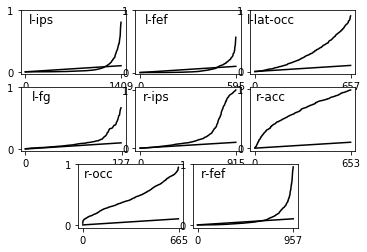

In [65]:
img = nib.load(clr_replication)
rois = img.get_data()
rmin, rmax = rois.min(), rois.max()
zstat = nib.load(contrasts["clr_lag1_priming"])

new_rois = []
roi_indexes = range(rmin+1, rmax+1)
fig, axes = create_subplots(len(roi_indexes))
qval = .1
df = pd.DataFrame()

for i, index in enumerate(roi_indexes):
    mask = (rois == index)
    thr, zthr, pvals, thrline, pcor, padj = fdr(zstat.get_data(), q=qval, mask=mask, invert_zscores=True)  

    name = list(table3.keys())[i]
    if thr:
        print(name, (thr > pvals).sum(), len(pvals))
    if len(thrline):
        axes[i].plot(thrline, "k-")
        axes[i].plot(pvals, "k-")
        axes[i].set_title(name, y=.7, x=.2)
        axes[i].set_yticks([0, 1])
        axes[i].set_xticks([0, len(pvals)])
    else:
        axes[i].set_title(name)
        axes[i].text(.2, .5, "out of scope")

    indexes = np.indices(mask.shape).reshape((3, mask.size)).T
    values = (zstat.get_data() * mask).reshape(mask.size)
    
    peak_coord = indexes[values == values.min()]
    peak_value = values.min()
    n_voxels = 0 if thr is None else (pvals < thr).sum()

    row = [ name, n_voxels, peak_value ] + list(np.squeeze(peak_coord)) + list(index2mni(*peak_coord))
    df = df.append(pd.DataFrame([row], columns=["name", "nvoxels", "peak", "x", "y", "z", "X", "Y", "Z"]), ignore_index=True)
        
    if thr is not None:
        roi_select = (zstat.get_data() < zthr)
        mask *= roi_select    
        new_rois.append(mask.astype(int))

order = np.argsort([roi.sum() for roi in new_rois])
new_img = np.zeros(zstat.shape)
for i, roi in enumerate(np.array(new_rois)[order]):
    new_img += roi * (i+1)
    
out_fname = "clr1_replication.nii.gz"
overlap_path = os.path.join(output, "postprocessing", out_fname)
save_nii(new_img, zstat.affine, overlap_path)

df = df.sort_values(by="nvoxels", ascending=False).round(2)
df

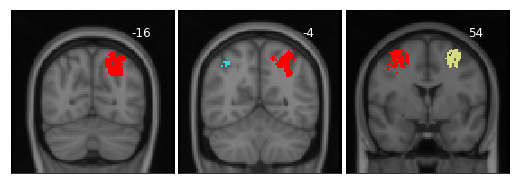

In [66]:
slices = get_slices(df[df.nvoxels > 0], axis="y")
idx = [ slice(None), slice(None), slice(None)]
idx[coronal] = 50
ncols = 4
nrows = int(np.ceil(len(slices) / ncols))
size = np.array([ncols, nrows]) / np.rot90(mni[tuple(idx)]).shape * np.mean(np.rot90(mni[tuple(idx)]).shape) * 3
y, x = size
fig, axes = create_subplots(len(slices), ncols=ncols, figsize=(y, x))

for i, ax in enumerate(axes):
    peak = slices[i]
    idx[coronal] = peak
    ax.imshow(
        np.rot90(mni[tuple(idx)]),
        cmap=dark,
        aspect=1, 
        interpolation="nearest",
    )
    
    img = np.ma.masked_array(
        np.rot90(new_img[tuple(idx)]), 
        np.rot90(new_img[tuple(idx)]) == 0)
    
    ax.imshow(img, cmap="rainbow", vmin=0, vmax=len(slices))
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_title("%d" % (index2mni((peak, peak, peak))[axial]), x=.8, y=.8, color="white")
              
fig.subplots_adjust(wspace=0, hspace=0)

## color lag2

l-ips 1409
l-fef 595
l-lat-occ 657
l-fg 127
r-ips 915
r-acc 653
r-occ 665
r-fef 957


,name,nvoxels,peak,x,y,z,X,Y,Z
7,r-fef,190,-3.72,26,64,57,38,2,42
0,l-ips,102,-3.67,57,30,63,-24,-66,54
4,r-ips,8,-4.31,28,34,60,34,-58,48
1,l-fef,0,-3.41,60,59,63,-30,-8,54
2,l-lat-occ,0,-2.35,56,23,34,-22,-80,-4
3,l-fg,0,-1.51,67,29,31,-44,-68,-10
5,r-acc,0,-2.32,49,61,60,-8,-4,48
6,r-occ,0,-2.76,45,22,32,0,-82,-8


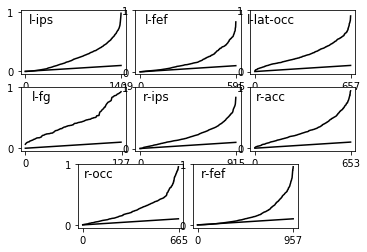

In [78]:
img = nib.load(clr_replication)
rois = img.get_data()
rmin, rmax = rois.min(), rois.max()
zstat = nib.load(contrasts["clr_lag2_priming"])

new_rois = []
roi_indexes = range(rmin+1, rmax+1)
fig, axes = create_subplots(len(roi_indexes))
qval = .1
df = pd.DataFrame()

for i, index in enumerate(roi_indexes):
    mask = (rois == index)
    thr, zthr, pvals, thrline, pcor, padj = fdr(zstat.get_data(), q=qval, mask=mask, invert_zscores=True)  


    name = list(table3.keys())[i]
    if len(thrline):
        axes[i].plot(thrline, "k-")
        axes[i].plot(pvals, "k-")
        axes[i].set_title(name, y=.7, x=.2)
        axes[i].set_yticks([0, 1])
        axes[i].set_xticks([0, len(pvals)])
    else:
        axes[i].set_title(title)
        axes[i].text(.2, .5, "out of scope")

    print(name, len(pvals))
    indexes = np.indices(mask.shape).reshape((3, mask.size)).T
    values = (zstat.get_data() * mask).reshape(mask.size)
    
    peak_coord = indexes[values == values.min()]
    peak_value = values.min()
    n_voxels = 0 if thr is None else (pvals < thr).sum()

    row = [ name, n_voxels, peak_value ] + list(np.squeeze(peak_coord)) + list(index2mni(*peak_coord))
    df = df.append(pd.DataFrame([row], columns=["name", "nvoxels", "peak", "x", "y", "z", "X", "Y", "Z"]), ignore_index=True)
        
    if thr is not None:
        roi_select = (zstat.get_data() < zthr)
        mask *= roi_select    
        new_rois.append(mask.astype(int))

order = np.argsort([roi.sum() for roi in new_rois])
new_img = np.zeros(zstat.shape)
for i, roi in enumerate(np.array(new_rois)[order]):
    new_img += roi * (i+1)

out_fname = "clr2_replication.nii.gz"
overlap_path = os.path.join(output, "postprocessing", out_fname)
save_nii(new_img, zstat.affine, overlap_path)

df = df.sort_values(by="nvoxels", ascending=False).round(2)
df

In [68]:
# peak_rois = np.zeros(zstat.shape)
# sph = Sphere(radius=3)

# for i, idx in enumerate(df[df.nvoxels > 0].index):    
#     # To integers
#     x, y, z = df.loc[idx, ["x", "y", "z"]]
#     print(i)
#     # Create sphere selection in MNI
#     x_slice = slice(x-sph.radius, x+sph.radius+1)
#     y_slice = slice(y-sph.radius, y+sph.radius+1)
#     z_slice = slice(z-sph.radius, z+sph.radius+1)
    
#     peak_rois[x_slice, y_slice, z_slice] = sph.box.astype(int) * (i+1)

# save_nii(peak_rois, zstat.affine, os.path.join(post, "clr2_replication_peak_rois.nii.gz"))

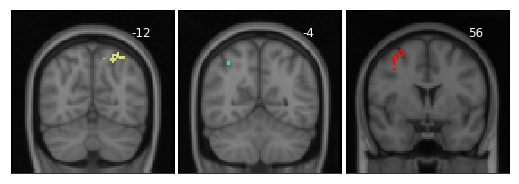

In [69]:
slices = get_slices(df[df.nvoxels > 0], axis="y")
idx = [ slice(None), slice(None), slice(None)]
idx[coronal] = 50
ncols = 4
nrows = int(np.ceil(len(slices) / ncols))
size = np.array([ncols, nrows]) / np.rot90(mni[tuple(idx)]).shape * np.mean(np.rot90(mni[tuple(idx)]).shape) * 3
y, x = size
fig, axes = create_subplots(len(slices), ncols=ncols, figsize=(y, x))

for i, ax in enumerate(axes):
    peak = slices[i]
    idx[coronal] = peak
    ax.imshow(
        np.rot90(mni[tuple(idx)]),
        cmap=dark,
        aspect=1, 
        interpolation="nearest",
    )
    
    img = np.ma.masked_array(
        np.rot90(new_img[tuple(idx)]), 
        np.rot90(new_img[tuple(idx)]) == 0)
    
    ax.imshow(img, cmap="rainbow", vmin=0, vmax=len(slices))
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_title("%d" % (index2mni((peak, peak, peak))[axial]), x=.8, y=.8, color="white")

              
fig.subplots_adjust(wspace=0, hspace=0)

# Location

![title](img/table2.png)

In [70]:
# location
table2 = {
    "lips"    : (-30, -60, 40),
    "lfef"    : (-32, -12, 54),
#     "lmfg"    : (-34, 36,  18),
    "lpc"     : (-8, -70,  8),
    "rfef"    : (28, -8, 56),
#     "rmfg"    : (28, 26, 22),
#     "rifg"    : (44, -18, -4),
#     "racc"    : (2, 22, 36),
    "rap"     : (34, -34, 60),
    "rip"     : (48, -42, 40),
    "rpc"     : (14, -68, 20),
    "rips"    : (24, -66, 48),
}

In [71]:
mni_path = os.path.join(standard, "MNI152_T1_2mm.nii.gz")
rois = np.zeros(nib.load(mni_path).shape, dtype=int)
sph = Sphere(radius=8)

for i, (roi, m) in enumerate(table2.items()):

    # To integers
    x, y, z = mni2index(m)
    
    # Create sphere selection in MNI
    x_slice = slice(x-sph.radius, x+sph.radius+1)
    y_slice = slice(y-sph.radius, y+sph.radius+1)
    z_slice = slice(z-sph.radius, z+sph.radius+1)
    
    rois[x_slice, y_slice, z_slice] = sph.box.astype(int) * (i+1)

rois *= base_mask.astype(int)

loc_replication = os.path.join(post, "loc_replication_rois.nii.gz")
save_nii(rois, nib.load(mni_path).affine, loc_replication)

## Location lag1

lfef 159 1379
rfef 112 862


,name,nvoxels,peak,x,y,z,X,Y,Z
1,lfef,159,-4.011864,58,58,61,-26,-10,50
3,rfef,112,-4.108569,29,57,64,32,-12,56
0,lips,0,-3.201391,62,39,60,-34,-48,48
2,lpc,0,-2.345659,50,26,37,-10,-74,2
4,rap,0,-2.126096,26,42,65,38,-42,58
5,rip,0,-2.914163,21,49,58,48,-28,44
6,rpc,0,-2.434510,36,26,39,18,-74,6
7,rips,0,-3.525503,34,28,66,22,-70,60


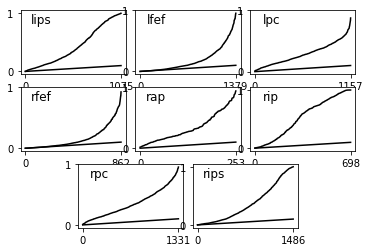

In [72]:
img = nib.load(loc_replication)
rois = img.get_data()
rmin, rmax = int(rois.min()), int(rois.max())
zstat = nib.load(contrasts["loc_lag1_priming"])

new_rois = []
roi_indexes = range(rmin+1, rmax+1)
fig, axes = create_subplots(len(roi_indexes))
qval = .1
df = pd.DataFrame()

for i, index in enumerate(roi_indexes):
    mask = (rois == index)
    thr, zthr, pvals, thrline, pcor, padj = fdr(zstat.get_data(), q=qval, mask=mask, invert_zscores=True)  

    name = list(table2.keys())[i]
    
    if thr:
        print(name, (pvals < thr).sum(), len(pvals))
    if len(thrline):
        axes[i].plot(thrline, "k-")
        axes[i].plot(pvals, "k-")
        axes[i].set_title(name, y=.7, x=.2)
        axes[i].set_yticks([0, 1])
        axes[i].set_xticks([0, len(pvals)])
    else:
        axes[i].set_title(list(table2.keys())[i])
        axes[i].text(.2, .5, "out of scope")

    indexes = np.indices(mask.shape).reshape((3, mask.size)).T
    values = (zstat.get_data() * mask).reshape(mask.size)
    
    peak_coord = indexes[values == values.min()]
    peak_value = values.min()
    n_voxels = 0 if thr is None else (pvals < thr).sum()

    row = [ name, n_voxels, peak_value ] + list(np.squeeze(peak_coord)) + list(index2mni(*peak_coord))
    df = df.append(pd.DataFrame([row], columns=["name", "nvoxels", "peak", "x", "y", "z", "X", "Y", "Z"]), ignore_index=True)

    if thr is not None:
        roi_select = (zstat.get_data() < zthr)
        mask *= roi_select    
        new_rois.append(mask.astype(int))

order = np.argsort([roi.sum() for roi in new_rois])
new_img = np.zeros(zstat.shape)
for i, roi in enumerate(np.array(new_rois)[order]):
    new_img += roi * (i+1)


out_fname = "loc1_replication.nii.gz"
overlap_path = os.path.join(output, "postprocessing", out_fname)
save_nii(new_img, zstat.affine, overlap_path)

df = df.sort_values(by="nvoxels", ascending=False)
df

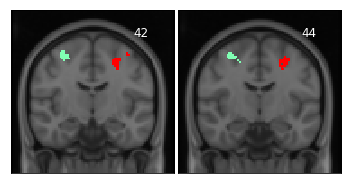

In [73]:
slices = get_slices(df[df.nvoxels > 0], axis="y")
idx = [ slice(None), slice(None), slice(None)]
idx[coronal] = 50
ncols = 2
nrows = int(np.ceil(len(slices) / ncols))
size = np.array([ncols, nrows]) / np.rot90(mni[tuple(idx)]).shape * np.mean(np.rot90(mni[tuple(idx)]).shape) * 3
y, x = size
fig, axes = create_subplots(len(slices), ncols=ncols, figsize=(y, x))

for i, ax in enumerate(axes):
    peak = slices[i]
    idx[coronal] = peak
    ax.imshow(
        np.rot90(mni[tuple(idx)]),
        cmap=dark,
        aspect=1, 
        interpolation="nearest",
    )
    
    img = np.ma.masked_array(
        np.rot90(new_img[tuple(idx)]), 
        np.rot90(new_img[tuple(idx)]) == 0)
    
    ax.imshow(img, cmap="rainbow", vmin=0, vmax=len(slices))
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_title("%d" % (index2mni((peak, peak, peak))[axial]), x=.8, y=.8, color="white")

              
fig.subplots_adjust(wspace=0, hspace=0)

## location lag2

lips 878 1075
lips 1075
lfef 184 1379
lfef 1379
lpc 1157
rfef 459 862
rfef 862
rap 253
rip 347 698
rip 698
rpc 1331
rips 1338 1486
rips 1486


,name,nvoxels,peak,x,y,z,X,Y,Z
7,rips,1338,-4.792711,32,32,57,26,-62,42
0,lips,878,-4.145394,60,28,62,-30,-70,52
3,rfef,459,-3.805620,27,63,66,36,0,60
5,rip,347,-4.270417,21,45,61,48,-36,50
1,lfef,184,-3.627932,60,61,62,-30,-4,52
2,lpc,0,-2.476011,47,35,38,-4,-56,4
4,rap,0,-2.453212,22,45,66,46,-36,60
6,rpc,0,-2.796895,32,31,49,26,-64,26


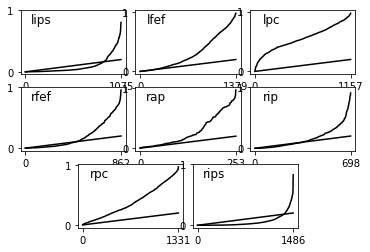

In [77]:
img = nib.load(loc_replication)
rois = img.get_data()
rmin, rmax = rois.min(), rois.max()
zstat = nib.load(contrasts["loc_lag2_priming"])

new_rois = []
roi_indexes = range(rmin+1, rmax+1)
fig, axes = create_subplots(len(roi_indexes))
qval = .2
df = pd.DataFrame()

for i, index in enumerate(roi_indexes):
    mask = (rois == index)
    thr, zthr, pvals, thrline, pcor, padj = fdr(zstat.get_data(), q=qval, mask=mask, invert_zscores=True)  

    name = list(table2.keys())[i]
    if thr:
        print(name, (pvals < thr).sum(), len(pvals))
    print(name, len(pvals))

    if len(thrline):
        axes[i].plot(thrline, "k-")
        axes[i].plot(pvals, "k-")
        axes[i].set_title(name, y=.7, x=.2)
        axes[i].set_yticks([0, 1])
        axes[i].set_xticks([0, len(pvals)])
    else:
        axes[i].set_title(list(table3.keys())[i])
        axes[i].text(.2, .5, "out of scope")

    indexes = np.indices(mask.shape).reshape((3, mask.size)).T
    values = (zstat.get_data() * mask).reshape(mask.size)
    
    peak_coord = indexes[values == values.min()]
    peak_value = values.min()
    n_voxels = 0 if thr is None else (pvals < thr).sum()

    row = [ name, n_voxels, peak_value ] + list(np.squeeze(peak_coord)) + list(index2mni(*peak_coord))
    df = df.append(pd.DataFrame([row], columns=["name", "nvoxels", "peak", "x", "y", "z", "X", "Y", "Z"]), ignore_index=True)
        
    if thr is not None:
        roi_select = (zstat.get_data() < zthr)
        mask *= roi_select    
        new_rois.append(mask.astype(int))

order = np.argsort([roi.sum() for roi in new_rois])
new_img = np.zeros(zstat.shape)
for i, roi in enumerate(np.array(new_rois)[order]):
    new_img += roi * (i+1)

out_fname = "loc2_replication.nii.gz"
overlap_path = os.path.join(output, "postprocessing", out_fname)
save_nii(new_img, zstat.affine, overlap_path)

df = df.sort_values(by="nvoxels", ascending=False)
df

In [75]:
peak_rois = np.zeros(zstat.shape)
sph = Sphere(radius=3)

for i, idx in enumerate(df[df.nvoxels > 0].index):    
    # To integers
    x, y, z = df.loc[idx, ["x", "y", "z"]]
    
    # Create sphere selection in MNI
    x_slice = slice(x-sph.radius, x+sph.radius+1)
    y_slice = slice(y-sph.radius, y+sph.radius+1)
    z_slice = slice(z-sph.radius, z+sph.radius+1)
    
    peak_rois[x_slice, y_slice, z_slice] = sph.box.astype(int) * (i+1)

save_nii(peak_rois, zstat.affine, os.path.join(post, "loc2_replication_peak_rois.nii.gz"))

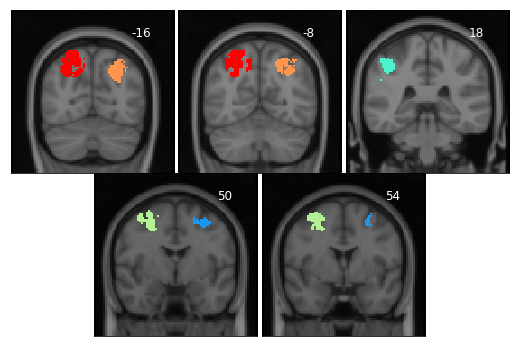

In [55]:
slices = get_slices(df[df.nvoxels > 0], axis="y")
idx = [ slice(None), slice(None), slice(None)]
idx[coronal] = 50
ncols = 3
nrows = int(np.ceil(len(slices) / ncols))
size = np.array([ncols, nrows]) / np.rot90(mni[tuple(idx)]).shape * np.mean(np.rot90(mni[tuple(idx)]).shape) * 3
y, x = size
fig, axes = create_subplots(len(slices), ncols=ncols, figsize=(y, x))

for i, ax in enumerate(axes):
    peak = slices[i]
    idx[coronal] = peak
    ax.imshow(
        np.rot90(mni[tuple(idx)]),
        cmap=dark,
        aspect=1, 
        interpolation="nearest",
    )
    
    img = np.ma.masked_array(
        np.rot90(new_img[tuple(idx)]), 
        np.rot90(new_img[tuple(idx)]) == 0)
    
    ax.imshow(img, cmap="rainbow", vmin=0, vmax=len(slices))
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_title("%d" % (index2mni((peak, peak, peak))[axial]), x=.8, y=.8, color="white")

              
fig.subplots_adjust(wspace=0, hspace=0)